In [219]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager as fm
import datetime as dt
from matplotlib.dates import DateFormatter, DayLocator, YearLocator

fm.findfont('Helvetica')

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


'/usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'

In [165]:
# Going to put all of the above processes into a function 
# since I need to do this again for each of the three islands on their own.
# I'd like to keep the date range the same for all islands (even though they each had different durations of transmission)
# and so I'm specifing the date range as an argument in the function.

def linelist_to_epicurve(linelist, date_column_name, indexing_linelist, frequency):
    """ This function takes in the following arguments:
    linelist: this is a pandas dataframe
    date_column_name: A string that specifies the df column name that has the dates you want to use
    indexing_linelist: The linelist that has the entire date range you care about. This ensures that you get 
    equal length dataframes between for example, a country-level line list with individual county level linelists as well.
    frequency: either "d" for daily, or "w" for incident cases grouped into weeks. Note these ARE NOT epi weeks, but rather weeks
    as defined by the start day of your line list.
    """
    day_index = pd.date_range(indexing_linelist[date_column_name].min(), indexing_linelist[date_column_name].max(), freq="d")#get index object for every day between first and last cases in linelist
    case_counts_per_day = pd.DataFrame(linelist[date_column_name].value_counts().sort_index()) #get total case counts for each day that has one or more reported cases
    empty_curve = case_counts_per_day.reindex(day_index).fillna(0)#make a epi curve based off of the index object. Have a column for every day in the range, set cases at 0.
    epi_curve = empty_curve.add(case_counts_per_day).fillna(0) #then add the actual case counts to that df. If a day didn't have any cases, then the 0 from the previous df remains unchanged.

    if frequency == "w":
        epi_curve = epi_curve.resample('W', closed="right").sum()
        
    epi_curve = epi_curve.rename(columns={date_column_name: "caseCount"})
    
    return epi_curve


def timestampToDecimalDate(sampling_date):
    """ This function takes in a Datetime Timestamp object and retuns the decimal date format of the date.
        Note that the decimal date will count all time UP TO the specified calendar date. For example, if my date is Jan 3,
        then the decimal fraction will represent two days worth of seconds (all the seconds of Jan 1 and Jan 2).
        
        Also note that this function requires the timestamp to be in Datetime format, which is DIFFERENT than pandas'
        timestamp format. Therefore, if dates are coming from a pandas df, you'll likely need to convert them with x.to_pydatetime()
        before you can pass them to thus function."""
    
    year =  sampling_date.year
    beginning_of_year = dt.datetime(year,1,1) #year, month, day, so year 1,1 == beginning of year
    end_of_year = dt.datetime(year+1,1,1) #next year 1,1 is a full year away from beginning of sampling year
    #return fraction of the full year (in seconds) that occurs between jan 1st and your sampling date
    return year + ((sampling_date - beginning_of_year).total_seconds() / ((end_of_year - beginning_of_year).total_seconds()))


In [23]:
#let's just get a sense of what the overall duration of the outbreak is.
combined_islands_linelist = pd.read_csv("../data/epi-data/epi-surveillance-data-cases-only-abridged.csv")
day_index = pd.date_range(combined_islands_linelist["SymptomOnsetDate"].min(), combined_islands_linelist["SymptomOnsetDate"].max(), freq='d')
print(("There are {} days between the first case and last case in our dataset.").format(len(day_index)))
print(("The first case was recorded on {}.").format(min(day_index)))
print(("The last case was recorded on {}.").format(max(day_index)))

There are 507 days between the first case and last case in our dataset.
The first case was recorded on 2016-01-03 00:00:00.
The last case was recorded on 2017-05-23 00:00:00.


In [166]:
saint_croix_linelist = pd.read_csv("../data/epi-data/saint-croix-cases-linelist.csv")
saint_thomas_linelist = pd.read_csv("../data/epi-data/saint-thomas-cases-linelist.csv")
saint_john_linelist = pd.read_csv("../data/epi-data/saint-john-cases-linelist.csv")

#daily epi curves (could use weekly if I wanted by specifying freq="w")
daily_combined_islands_epicurve = linelist_to_epicurve(combined_islands_linelist, "SymptomOnsetDate", all_islands_linelist, "d")
daily_saint_croix_epicurve = linelist_to_epicurve(saint_croix_linelist, "SymptomOnsetDate", all_islands_linelist, "d")
daily_saint_thomas_epicurve = linelist_to_epicurve(saint_thomas_linelist, "SymptomOnsetDate",  all_islands_linelist,"d")
daily_saint_john_epicurve = linelist_to_epicurve(saint_john_linelist, "SymptomOnsetDate",  all_islands_linelist,"d")

In [169]:
#export the incidence data to CSV in case I want to import into a different notebook later.
combined_islands_epicurve.to_csv("../data/epi-data/daily_incidence_all_islands.csv", index_label="date")
saint_croix_epicurve.to_csv("../data/epi-data/daily-incidence-saint-croix.csv", index_label = "date")
saint_thomas_epicurve.to_csv("../data/epi-data/daily-incidence-saint-thomas.csv", index_label = "date")
saint_john_epicurve.to_csv("../data/epi-data/daily_incidence_saint_john.csv", index_label = "date")

In [220]:
#for zika most epi curves were reported as cases per week, so I'm going to do that for my epi curves here as well.
weekly_saint_croix_epicurve = linelist_to_epicurve(saint_croix_linelist, "SymptomOnsetDate", all_islands_linelist, "w")
weekly_saint_thomas_epicurve = linelist_to_epicurve(saint_thomas_linelist, "SymptomOnsetDate",  all_islands_linelist,"w")
weekly_saint_john_epicurve = linelist_to_epicurve(saint_john_linelist, "SymptomOnsetDate",  all_islands_linelist,"w")

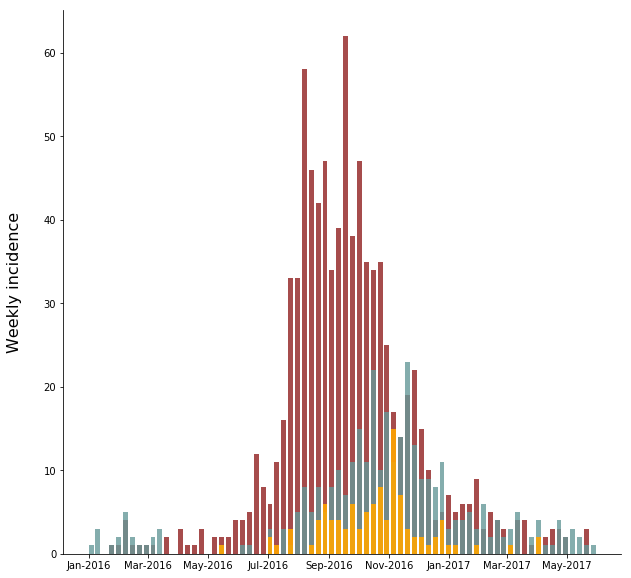

In [278]:
usvi_island_colors = {'saint_croix': '#669999', 'saint_thomas': '#800000' ,'saint_john': '#ffa500'}

import matplotlib.dates as mdates


fig,ax = plt.subplots(figsize=(10,10),facecolor="white")

#x values.
dates = [x for x in weekly_saint_croix_epicurve.index]

#y values
stx_y_values = [y for y in weekly_saint_croix_epicurve["caseCount"]]
stt_y_values = [y for y in weekly_saint_thomas_epicurve["caseCount"]]
stj_y_values = [y for y in weekly_saint_john_epicurve["caseCount"]]

#plotting
plt.bar(dates, stt_y_values,  width = 5, alpha = 0.7, color = usvi_island_colors["saint_thomas"])
plt.bar(dates, stx_y_values, width = 5, alpha = 0.8, color = usvi_island_colors["saint_croix"])
plt.bar(dates, stj_y_values,  width = 5, alpha = 0.9, color = [usvi_island_colors["saint_john"]])

#remove annoying extraneous lines
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)

#axis labeling and formatting
ax.set_ylabel('Weekly incidence\n',size=16)
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))